In this notebook, we merge all the previous datasets containing different categories of variables.
We also need to drop some NaNs as these are problematic in running linear models and diagnostics. 

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [6]:
df_pac = pd.read_csv('df_pac.csv')

#read in controls df_controls
df_controls = pd.read_csv('df_controls.csv')

#read in IVs df_gov.csv, df_ind.csv
df_gov = pd.read_csv('df_gov.csv')
df_ind = pd.read_csv('df_ind.csv')

#merge IVs
df_iv = pd.merge(df_gov, df_ind, on=['country', 'year'], how='outer')
df_iv = pd.merge(df_iv, df_controls, on=['country', 'year'], how='outer')

#merge all
df = pd.merge(df_pac, df_iv, on=['country', 'year'], how='outer')

df.head()

,country,year,GENpac,RCOpac,RECpac,GENplas,RCOplas,RECplas,gov_right1,gov_cent1,...,EPS,TAXrespol_eur_log,TAXrespol_per_log,INDrec,INDred,INDimp,GDPpc,POPden,URB,EDU
0,Austria,2004,134.83,111.05,89.28,27.55,22.76,9.13,25.00,66.67,...,2.194444,2.140329,-3.506558,68.0,43.0,2.74,33523.020497,99.030126,59.094,15.8
1,Austria,2005,135.08,115.33,90.41,27.35,24.00,8.99,25.00,66.67,...,2.305556,1.970862,-3.912023,NaN,NaN,NaN,34776.669954,99.707089,58.813,15.0
2,Austria,2006,141.06,123.38,96.46,28.80,26.12,10.30,25.00,66.67,...,2.527778,2.309018,-3.506558,NaN,NaN,NaN,37396.035096,100.201660,58.532,14.7
3,Austria,2007,142.79,128.87,95.89,29.49,28.09,9.66,0.68,50.46,...,2.250000,2.298419,-3.506558,NaN,NaN,NaN,39193.817364,100.526987,58.249,14.6
4,Austria,2008,141.82,129.82,96.31,30.23,29.41,10.54,0.00,50.00,...,2.666667,2.203567,-3.506558,50.0,44.0,3.40,41046.790035,100.842172,57.966,15.0


In [7]:
# log transform GDPpc and POPden
df['GDPpc_log'] = np.log(df['GDPpc'])
df['POPden_log'] = np.log(df['POPden'])

In [10]:
# Set panel index
#df = df.set_index(["country", "year"])

#reset index
df = df.reset_index()

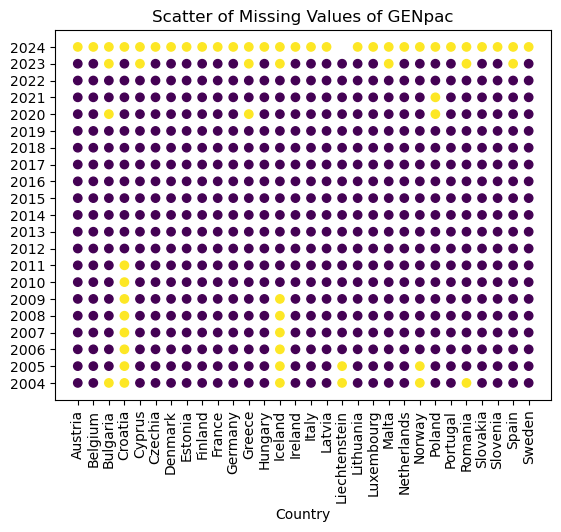

In [11]:
#check patterns of missingness

#plot a scatter of missing values of GENpac where country is on the x axis and year on the y axis
plt.scatter(df['country'], df['year'], c=df['GENpac'].isnull())
plt.xlabel('Country')
#rotate xlabel 90 degrees
plt.xticks(rotation=90)
#year is integer
plt.yticks(df['year'].unique())
plt.title('Scatter of Missing Values of GENpac')
plt.show()

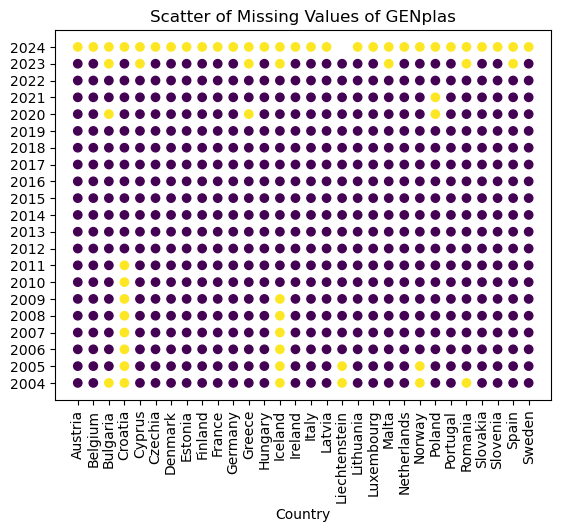

In [12]:
#plot a scatter of missing values of GENplas where country is on the x axis and year on the y axis
plt.scatter(df['country'], df['year'], c=df['GENplas'].isnull())
plt.xlabel('Country')
#rotate xlabel 90 degrees
plt.xticks(rotation=90)
#year is integer
plt.yticks(df['year'].unique())
plt.title('Scatter of Missing Values of GENplas')
plt.show()

In [25]:
#based on missingness in GENpac and GENplas

#filter out year 2024 in df
df_new = df[df['year'] != 2024]

In [26]:
#create a new column RECpac_percent
df_new['RECpac_percent'] = df_new['RECpac'] / df_new['GENpac']

#create a new column RECplas_percet
df_new['RECplas_percent'] = df_new['RECplas'] / df_new['GENplas']

C:\Users\lzho\AppData\Local\Temp\ipykernel_24692\1604191824.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['RECpac_percent'] = df_new['RECpac'] / df_new['GENpac']
C:\Users\lzho\AppData\Local\Temp\ipykernel_24692\1604191824.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['RECplas_percent'] = df_new['RECplas'] / df_new['GENplas']


Now run some descriptive statistics. We are interested in 
1) overall, between, within mean, sd, min, and max.
2) correlation matrix 
3) VIF to check multicollinearity

In [39]:
# select variables of interest

#df_new.set_index(['country', 'year'], inplace=True)

df_vars = df_new[['GDPpc_log', 'POPden_log', 
              'URB', 'EDU', 'gov_right1', 'EPS',
              'INDimp', 'INDrec', 'INDred',
              'GENpac', 'RECpac', 'RECpac_percent',
              'GENplas', 'RECplas', 'RECplas_percent']]

# drop NAs
df_vars= df_vars.dropna()

In [28]:
# descriptive statistics

def summary_stats(df, var, entity_col = 'country'):

  #drop missing values
  series = df[var].dropna()

  #overall stats
  overall_mean = series.mean()
  overall_std = series.std()
  overall_min = series.min()
  overall_max = series.max()
  overall_obs = series.shape[0]

  #between stats
  entity_means = df[var].groupby(entity_col).mean()
  between_mean = entity_means.mean()
  between_std = entity_means.std()
  between_min = entity_means.min()
  between_max = entity_means.max()
  n_groups = entity_means.shape[0]


  #within stats
  demeaned = df[var] - df[var].groupby(entity_col).transform('mean')
  within_mean = demeaned.mean()
  within_std = demeaned.std()
  within_min = demeaned.min()
  within_max = demeaned.max()

  summary = pd.DataFrame({
        "mean": [overall_mean, between_mean, np.nan],
        "std": [overall_std, between_std, within_std],
        "min": [overall_min, between_min, within_min],
        "max": [overall_max, between_max, within_max],
        "obs/groups": [overall_obs, n_groups, np.nan]
    }, index=["Overall", "Between", "Within"])

  return summary

In [ ]:
summary_stats(df_vars, 'GENpac')

# and so on for other variables

,mean,std,min,max,obs/groups
Overall,151.256417,44.260654,60.400000,228.700000,120.0
Between,151.256417,42.739737,81.800000,214.710000,20.0
Within,NaN,14.459318,-55.018333,38.501667,NaN


In [40]:
# correlation matrix

corr = df_vars.corr()

#display the correlation matrix
corr.style.background_gradient(cmap='coolwarm')

,GDPpc_log,POPden_log,URB,EDU,gov_right1,EPS,INDimp,INDrec,INDred,GENpac,RECpac,RECpac_percent,GENplas,RECplas,RECplas_percent
GDPpc_log,1.000000,0.184857,0.473856,0.662769,-0.209181,0.492831,0.302236,-0.043205,0.142112,0.652103,0.772343,0.629392,0.566721,0.627279,0.250336
POPden_log,0.184857,1.000000,0.180865,-0.210906,-0.065208,-0.078192,-0.077881,0.022404,0.100389,0.289889,0.415711,0.365407,0.095083,0.280991,0.240884
URB,0.473856,0.180865,1.000000,0.503287,0.049582,0.422720,0.152710,0.008166,-0.013197,0.296106,0.414759,0.415830,0.057447,0.070202,-0.013738
EDU,0.662769,-0.210906,0.503287,1.000000,-0.049459,0.461371,0.254431,-0.002518,-0.002836,0.370925,0.470855,0.443126,0.405129,0.402019,0.111431
gov_right1,-0.209181,-0.065208,0.049582,-0.049459,1.000000,0.049931,0.027764,0.016775,-0.196607,-0.132846,-0.213110,-0.216615,-0.061939,-0.245431,-0.200965
EPS,0.492831,-0.078192,0.422720,0.461371,0.049931,1.000000,0.416372,-0.216527,0.001951,0.352175,0.426417,0.417143,0.214093,0.251169,0.135118
INDimp,0.302236,-0.077881,0.152710,0.254431,0.027764,0.416372,1.000000,-0.220513,-0.225491,-0.060614,0.075408,0.319112,0.029040,0.261635,0.349694
INDrec,-0.043205,0.022404,0.008166,-0.002518,0.016775,-0.216527,-0.220513,1.000000,0.202779,-0.144854,-0.113411,-0.047736,-0.156405,-0.044982,0.098407
INDred,0.142112,0.100389,-0.013197,-0.002836,-0.196607,0.001951,-0.225491,0.202779,1.000000,0.148859,0.150657,-0.003529,0.041209,-0.021325,-0.130806
GENpac,0.652103,0.289889,0.296106,0.370925,-0.132846,0.352175,-0.060614,-0.144854,0.148859,1.000000,0.916293,0.331512,0.805314,0.551712,-0.096527


In [43]:
# add constant for VIF

df_iv = df_vars[['GDPpc_log', 'POPden_log',
              'URB', 'EDU', 'gov_right1', 'EPS',
              'INDimp', 'INDrec', 'INDred']]
var_const = sm.add_constant(df_iv)

# compute VIF
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(var_const, i) for i in range(var_const.shape[1])]
vif["features"] = var_const.columns
vif.round(2)

# --- checks out. All below 5

,VIF Factor,features
0,1427.60,const
1,2.76,GDPpc_log
2,1.47,POPden_log
3,1.66,URB
4,2.66,EDU
5,1.14,gov_right1
6,1.75,EPS
7,1.36,INDimp
8,1.14,INDrec
9,1.20,INDred


In [ ]:
#save df_new
df_new.to_csv('df_all_vars.csv', index=False)